<a href="https://colab.research.google.com/github/vipul43/project_MASK/blob/main/basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# importing dataset from kaggle
!pip install -q kaggle &> /dev/null
!mkdir ~/.kaggle &> /dev/null
!echo '{"username":"saivipul","key":"f4e9e153799bf7289426d9655d02fdca"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json &> /dev/null
# enter dataset API command below
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset &> /dev/null
!unzip face-mask-12k-images-dataset.zip &> /dev/null
!rm -rf face-mask-12k-images-dataset.zip &> /dev/null

# dataset is stored in 'Face Mask Dataset' folder

In [32]:
train_images_with_mask_path = '/content/Face Mask Dataset/Train/WithMask/'
train_images_without_mask_path = '/content/Face Mask Dataset/Train/WithoutMask/'

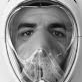

<class 'PIL.Image.Image'>
None
L
(82, 82)


In [79]:
# playing around with data
import numpy as np
from keras.preprocessing.image import load_img, img_to_array, array_to_img
image = load_img(train_images_with_mask_path+'10'+'.png', color_mode="grayscale", target_size=None, interpolation="nearest")
display(image)
print(type(image))
print(image.format)
print(image.mode)
print(image.size)

In [80]:
# converting image to vector
image_vec = img_to_array(image)
print(type(image_vec))
print(image_vec.dtype)
print(image_vec.shape)
print(image_vec)

<class 'numpy.ndarray'>
float32
(82, 82, 1)
[[[238.]
  [238.]
  [238.]
  ...
  [199.]
  [200.]
  [200.]]

 [[237.]
  [238.]
  [240.]
  ...
  [187.]
  [194.]
  [195.]]

 [[237.]
  [238.]
  [240.]
  ...
  [196.]
  [193.]
  [194.]]

 ...

 [[236.]
  [235.]
  [235.]
  ...
  [152.]
  [151.]
  [152.]]

 [[236.]
  [236.]
  [235.]
  ...
  [152.]
  [151.]
  [152.]]

 [[235.]
  [235.]
  [234.]
  ...
  [151.]
  [151.]
  [152.]]]


In [83]:
# loading entire images dataset
import tensorflow as tf
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/Face Mask Dataset/Train',
    labels="inferred",
    label_mode="binary",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
)
print(type(train_dataset))

Found 10000 files belonging to 2 classes.
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
